**INTRODUCTION**

We want to train and test an unsupervised generative model: the DBN (deep belief network);

So providing data distribution (EMNIST Dataset in this case) we want to discover features/representation of this data;
therefore our model doesn't require any label (is no a classifier) it just wants to build features hierarchically;

We want to build a complete model which takes generative models and readout layer and stack them together;

At the end we want to train the perceptron to have basically a classifier that takes as input the hidden representation from our the generative model (data produced by my DBN), instead of raw data.







# Load Data and Libreries

**Load** DBN neural network

---

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

**Download** the list_datasets of Emnist

---



In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import torch
import torchvision as tv
import tensorflow as tf

from DBN import DBN

To load the **train** and **test** samples for the 'lettes' subset:

In [4]:
%%capture
emnist_train = tv.datasets.EMNIST('data/', "letters", train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

emnist_test = tv.datasets.EMNIST('data/', "letters", train=False, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))


In [5]:
emnist_test.targets.shape

torch.Size([20800])

# Preprocessing Data


In [6]:
#Convert np.array into Pytorch Tensor and normalize them 
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255) 

In [7]:
emnist_data_train = np.array(emnist_train.data)
emnist_targets_train = emnist_train.targets

emnist_data_test = np.array(emnist_test.data)
emnist_targets_test = emnist_test.targets

In [8]:
#dictionary I'm going to use in the Cluster hierarchy method 
d = {chr(i+96):i for i in range(1,27)}
associated_char = [] 
for i in range(1,27):
  associated_char.append(chr(i+96))

In [9]:
#I have to rotate and flip all image of my datasets to creating new ones
def rotate(image):
    image = image.reshape([28, 28]) # they are all already 28x28 in size 
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

def show_img(idx):
  img = emnist_data_train[idx]
  print("The letter shown is: {}".format(associated_char[emnist_targets_train[idx]]))
  plt.imshow(img , cmap = 'gray')
  plt.show()

In [10]:
for index, image in enumerate(emnist_data_train):
  emnist_data_train[index] = rotate(emnist_data_train[index])

for index, image in enumerate(emnist_data_test):
  emnist_data_test[index] = rotate(emnist_data_test[index])

emnist_data_train = torch.from_numpy(emnist_data_train)
emnist_data_test = torch.from_numpy(emnist_data_test)

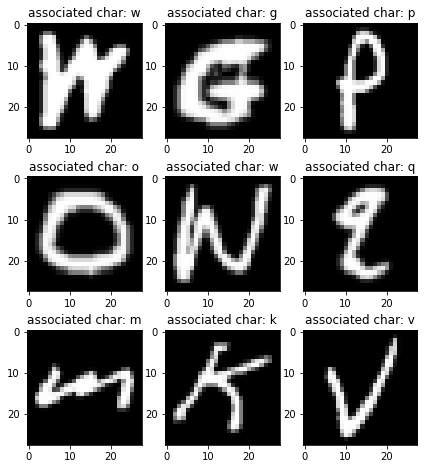

In [11]:
# plot images
cols = 3
rows = 3
fig = plt.figure(figsize=(7,8))
for i in range(0, 9):
    fig.add_subplot(rows, cols, (i+1)) 
    plt.title("associated char: {}".format( associated_char[ emnist_targets_train[i]-1 ]))
    plt.imshow(emnist_data_train[i], cmap=plt.get_cmap('gray')) 

#RBMs

A deep belief network consists of a sequence of restricted boltzmann machines which are sequentially connected. Each of the Boltzmann machines layers is trained until convergence, then frozen; the result of the "output" layer of the machine is then fed as input to the next Boltzmann machine in the sequence, which is then itself trained until convergence, and so forth, until the entire network has been trained.

In [12]:
dbn = DBN(visible_units=28*28,  #28 x 28 pixel
                hidden_units=[300, 600, 900], #list of 2 hidden layers of 256, 512 neurons unit for each layer
                k=1, # number of time that constrastic divergence is repeating this case 1 time
                learning_rate=0.1, # is the speed which we update the learning of the network
                learning_rate_decay=False, #the learning rate remain costant for all the training time 
                initial_momentum=0.5, # optimization parameter
                final_momentum=0.9,
                weight_decay=0.002, #L2 optimization parameter 
                xavier_init=False, 
                increase_to_cd_k=False,
                use_gpu=True)

#regolize Hyperparameters: lerning rate, momentum, weight decay



*   A DBN is a deep belief network which are basically stacked RBMs which are trained layerwise.
   
    *   If it has 1 layer then it is equivalent to training an RBM





In [13]:
# I'm going to train my DBN model:
num_epochs = 50
batch_size = 120

dbn.train_static(
    emnist_data_train,
    emnist_targets_train,
    num_epochs,
    batch_size
)

# we train the dbn for 50 epochs


--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.3379   |0.0517   |254.6463 |6.1253   |
|20    |1.3041   |0.0479   |249.4387 |6.1211   |
|30    |1.2926   |0.0483   |246.1560 |6.1612   |
|40    |1.2840   |0.0486   |244.5431 |6.1592   |
|50    |1.2794   |0.0488   |242.6954 |5.8103   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |2.2011   |0.0561   |211.7246 |5.6200   |
|20    |2.1675   |0.0535   |207.5005 |5.4038   |
|30    |2.1602   |0.0546   |205.7428 |5.1638   |
|40    |2.1537   |0.0549   |205.6865 |5.3431   |
|50    |2.1500   |0.0548   |204.7758 |5.1997   |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0002   |0.0286   |323.4939 |9.8093   |
|20    |0.9823   |0.0274   |310.4543 |9.2731   |
|30    |0.9775   |0.0275   |307.1392 |9.0298   |
|40    |0.9747   |0.0282   |303.9634 |9.6369   |
|50    |0.9750

In [14]:
def _move_parameters_to_cpu(dbn_emnist):
  for layer in dbn_emnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu() #hidden biases
    layer.v_bias = layer.v_bias.cpu() #visible biases


In [15]:
_move_parameters_to_cpu(dbn)

In [16]:
def _apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def _plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

***Below we can show how receptive fields of the rbm model can visualize the strength of the connection between the and first hidden layer and the visible layer (input data)***

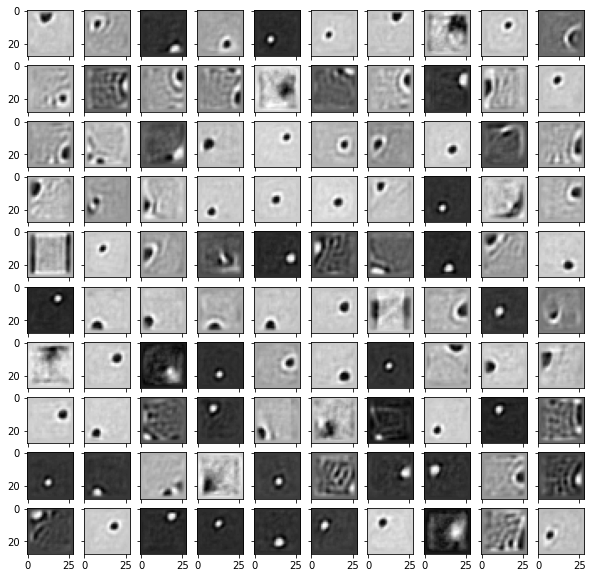

In [17]:
learned_weights_layer_1 = dbn.rbm_layers[0].W.transpose(0,1).numpy()
_plot_layer_receptive_fields(learned_weights_layer_1)

**explanation of the figure above**

*straightforward we want visualize the receptive field of these neurons. 
we consider the strenght of connections, after learning they rappresent features:*

*   gray mean 0
*   black is -1

*instead, the most significative weights are the one with black features in the border and white circles or lines inside*
*   white has value 1





The weights in the third hidden layer have dimensionality `(600, 900)`, i.e. they are vectors of `900` elements associated to each of the `300` nodes of the first layer. Therefore, we will need to project each of the vectors in a space of dimensionality `784 (28x28)` in order to visualize them as images.

First hidden representation layer shape
(300, 784)
Second hidden representation layer shape
(600, 300)
Third hidden representation layer shape
(900, 600)


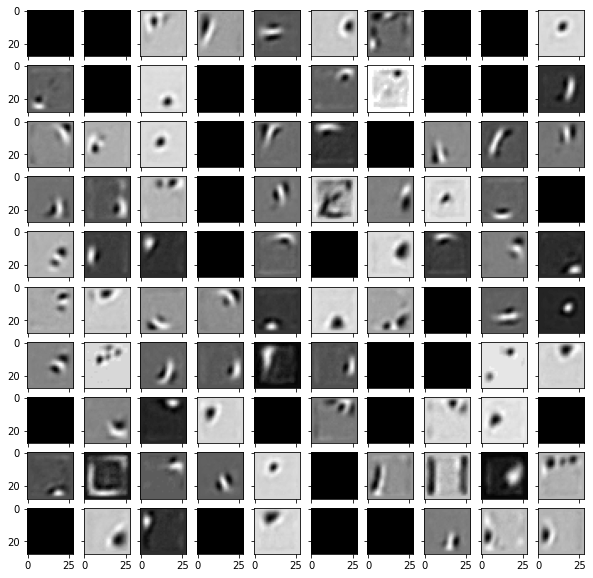

In [46]:
#First hidden representation layer 
# we simply consider the strength of the connection going from a neuron to the visible 
learned_weights_layer_1 = dbn.rbm_layers[0].W.transpose(0,1).numpy()
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, 0.1)
print("First hidden representation layer shape")
print(learned_weights_layer_1.shape)

#Second hidden representation layer
learned_weights_layer_2 = dbn.rbm_layers[1].W.transpose(0,1).numpy()
learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, 0.1)
print("Second hidden representation layer shape")
print(learned_weights_layer_2.shape)

#Third hidden representation layer
learned_weights_layer_3 = dbn.rbm_layers[2].W.transpose(0,1).numpy()
learned_weights_layer_3 = _apply_threshold(learned_weights_layer_3, 0.1)
print("Third hidden representation layer shape")
print(learned_weights_layer_3.shape)

learned_weights_product = (learned_weights_layer_3 @ learned_weights_layer_2 @ learned_weights_layer_1)  # here we do the projection  
learned_weights_product = _apply_threshold(learned_weights_product, 0.1)
_plot_layer_receptive_fields(learned_weights_product)

#Conclusion: in the first hidden representation we have on/off center detectors, in the second we could have edge detectors and in the third one we have more complex visual features

##Hierarchical clustering representations

Let's compute the hidden representations:


In [19]:
def _get_kth_layer_repr(input, k):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object,
  #I'm constructing the hidden representation from the data doing the W.x + c, and then I apply the sigmoid function (non-linear function) 
  return hidden_repr

In [20]:
#Here we want to get the hidden layer rappresentation
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0) #first hidden rappresentation layer 
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1) #second hidden rappresentation layer
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2) #second hidden rappresentation layer

In [21]:
def _get_mask(label):  # we use this function to filter by class
  labels = emnist_targets_train.numpy()
  return labels == label

def _get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.numpy()
  return {
    label: hidden_representation_np[_get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(1,27)
  }

def _get_hidden_reprs_matrix(label_to_mean_hidd_repr):  # we use this to build the matrices
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(1,27)])

In [22]:
label_to_mean_hidd_repr_1 = _get_label_to_mean_hidd_repr(hidden_repr_layer_1)
label_to_mean_hidd_repr_2 = _get_label_to_mean_hidd_repr(hidden_repr_layer_2)
label_to_mean_hidd_repr_3 = _get_label_to_mean_hidd_repr(hidden_repr_layer_3)

In [23]:
mean_hidd_repr_matrix_1 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)
mean_hidd_repr_matrix_2 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)
mean_hidd_repr_matrix_3 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_3)

In [24]:
def _plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots(figsize=(8, 3))
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dtest=[(elem) for elem in d]
  dendrogram = cluster.hierarchy.dendrogram( linkage, labels=dtest)
  ax.set_title(title)
  

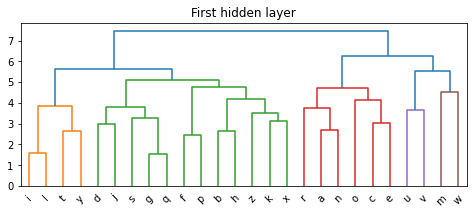

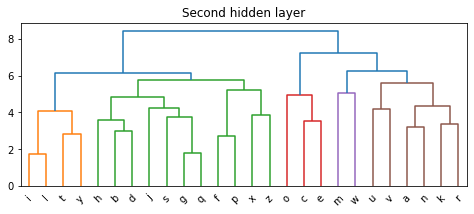

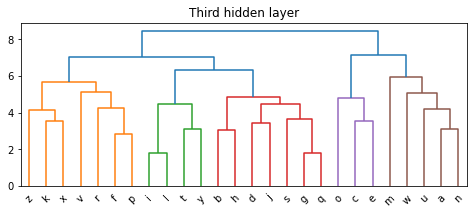

In [25]:
# fig, axes = plt.subplots(1, 3, figsize=(8, 3))
_plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer") 
_plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")
_plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")


**CONCLUSION CLUSTERING INTERNAL REPRESENTATIONS:**

1.   We have all letters of the same class (i.e. all “a”) 
2.   We should have hidden representation for “a” which are similar to the other representation and visualize them with some hierarchical clustering algorithm.
3.   We want to gather together similar letters

##Readout layer

Perceptron is the first neural network with synaptic weights that can be modify by a learning algorithm.
we take the perceptron to classify these representations  

In [26]:
class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 27)

  def forward(self, x):
    return self.linear(x)
# here we are going to train the readout layer that is basically:
# a linear classifier on the rappresentation produced by the DBN network

**Let's train the readout layer**
to optimize the network we are going the Stochastic 

In [27]:
def train(net, input, epochs = 1000):
  optimizer = torch.optim.SGD(net.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  print_every_n_epochs = 100 if epochs >= 1000 else 10 
  
  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = net(input) #input      
    # targets = emnist_targets_train.reshape(predictions.shape[0])
    loss = loss_fn(predictions, emnist_targets_train) #targets
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:  
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss)) 

In [28]:
rbm_third_layer_size = dbn.rbm_layers[2].W.shape[1]
perceptron_third_hidden = Perceptron(rbm_third_layer_size)
train(perceptron_third_hidden, hidden_repr_layer_3)

epoch 0/1000, loss = 3.332320
epoch 100/1000, loss = 1.898410
epoch 200/1000, loss = 1.511102
epoch 300/1000, loss = 1.347215
epoch 400/1000, loss = 1.253831
epoch 500/1000, loss = 1.191212
epoch 600/1000, loss = 1.145094
epoch 700/1000, loss = 1.109055
epoch 800/1000, loss = 1.079725
epoch 900/1000, loss = 1.055143



Let's now build the representation for the test set we kept apart at the beginning:

Why we did this training?
now we have this readout layer which is trained on the rappresentation of the training data 

In [29]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_data_test, 0) #first hidden layer 
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1) #second hidden layer
hidden_repr_layer_3_test = _get_kth_layer_repr(hidden_repr_layer_2_test, 2) #third hidden layer

hidden_repr_layer_2_test.shape
# we extract the rappresentation for the test data

torch.Size([20800, 600])

In [37]:
predictions_third_hidden = perceptron_third_hidden(hidden_repr_layer_3_test) # the labels predicted from the test 
# we use the model trained before to compute the labels (predictions) of this representation for the test data

In [38]:
predictions_first_hidden = _get_kth_layer_repr(emnist_data_test, 0)

In [39]:
def _compute_accuracy(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == emnist_targets_test).sum() / len(emnist_targets_test)
  return accuracy.item()

In [40]:
_compute_accuracy(predictions_third_hidden, emnist_targets_test)
#we see how good these rappresentation data are, then we will be able to classify this samples using the rappresentation we created

0.708509624004364

**Conclusion:**

We had a multiclassifier network for classifier many classes (27), therefore our network will has been confused by the multiple the representations of letters that resemble each other.

Our linear classifier didn't reach 99% so our linear readout network  is not able disentangle the representations 

there is an accuracy of 0.70

##Feedforward model

Let's now train a simple feedforward neural network with the same structure as the RBM, i.e. with three hidden layer with (300, 600, 900) units.

We want to compare a network that is trained end-to-end to solve a classification task with a simple classifier that solves the same task using representations of input data learned in an unsupervised way.


**NOTICE THAT:**
before we didn't trained the network to produce representation that are good to do classification, 
because in this case we are still build matrices inside the network that create certain hidden representations of the data (this always happen in neural netowrks); 
but this matrix is fine tuned to produce representations that can be used to solve a classification task, because we compare the label output by our feedfoward network with the true label during training; **instead** we did that before only for the last hidden layer (Readout network) in the previous network (but it's just a matrix moltiplication, linear layer, so it's not so powerfull).

In [41]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__() #call the superclass  
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 27)#this entire network is equivalent to the RBM(build a rappresentation of 500 dimention) + the readout layer (create a onehot encoding to solve the classification task)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input)) # we apply the linear function in the input and then we apply the nonLinearity on the output
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr) 
    return output

FeedFoward model that basically is a linear classifier with one non linearity
and we train it to classify the emnist data


In [42]:
ffnn = Feedforward(300, 600, 900) #we instantiate the model here

In [45]:
emnist_train.data.shape
ffnn

torch.Size([124800, 28, 28])

We choose the number of epochs to match the training time of the RBM and the readout layer combined.

In [47]:
train(ffnn, emnist_train.data.reshape((124800, 784)), epochs=120)

epoch 0/120, loss = 3.295205
epoch 10/120, loss = 3.291691
epoch 20/120, loss = 3.288203
epoch 30/120, loss = 3.284667
epoch 40/120, loss = 3.281009
epoch 50/120, loss = 3.277161
epoch 60/120, loss = 3.273044
epoch 70/120, loss = 3.268566
epoch 80/120, loss = 3.263622
epoch 90/120, loss = 3.258088
epoch 100/120, loss = 3.251830
epoch 110/120, loss = 3.244700


In [48]:
predictions_ffnn = ffnn(emnist_test.data.reshape((20800, 784)))

In [49]:
_compute_accuracy(predictions_ffnn, emnist_test.targets)

0.08461538702249527

**Conclusion:**
* The solutions obtained with deeper neural networks correspond to solutions that perform worse than the solutions obtained for networks with 1 or 2 hidden layers. As the architecture gets deeper, it becomes more difficult to obtain good generalization using a Deep NN.

**Curiosity:**
* In 2006 Hinton discovered that much better results could be achieved in deeper architectures when each layer (RBM) is pre-trained with an unsupervised learning algorithm (Contrastive Divergence). Then the Network can be trained in a supervised way using backpropagation in order to "fine-tune" the weights.



difference between the two architectures:

1. Deep Neural Networks (DNN) are feedforward Neural Networks with many layers. 
A Deep belief network is not the same as a Deep Neural Network.

2. Deep Belief Network (DBN) has undirected connections between some layers. This means that the topology of the DNN and DBN is different by definition.
The undirected layers in the DBN are called Restricted Boltzmann Machines (RBMs). This layers can be trained using an unsupervised learning algorithm (Contrastive Divergence) that is very fast



# Robustness to noise

We will now inject some noise in the input images and see how much the representations learned by the RBM are robust to noise.

Data augmentation -> helps deep learning to generalize well

In [50]:
def _inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape)/6.6 + .6
  probability_tensor = torch.ones(emnist_data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return emnist_data - mask_tensor * emnist_data + mask_tensor * random_gaussian_tensor

Let's see what a noisy image looks like:

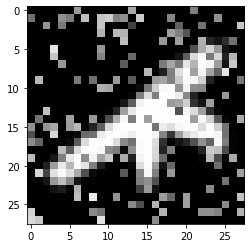

In [51]:
noise_level = 0.2
emnist_test_with_noise = _inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(emnist_test_with_noise[8312].reshape(28, 28), cmap="gray")

We will now compute the hidden representations for the noisy images using the RBM. Then, we will use the models that we trained on the representations without noise to classify the noisy ones.

In [52]:
def _get_accuracy_values_at_noise_level(noise_level):
  emnist_test_with_noise = _inject_noise(emnist_test.data, noise_level)

  hidden_repr_layer_1_noisy = _get_kth_layer_repr(emnist_test_with_noise, 0) #first hidden layer 
  hidden_repr_layer_2_noisy = _get_kth_layer_repr(hidden_repr_layer_1_noisy, 1) #second hidden layer
  hidden_repr_layer_3_noisy = _get_kth_layer_repr(hidden_repr_layer_2_noisy, 2) #third hidden layer

  predictions_third_hidden_noisy = perceptron_third_hidden(hidden_repr_layer_3_noisy)  # here we compute the representations
  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))

  accuracy_third_hidden = _compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)
  accuracy_ffnn = _compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)
  return accuracy_third_hidden, accuracy_ffnn

In [53]:
emnist_test.data.shape

torch.Size([20800, 28, 28])

In [54]:
_get_accuracy_values_at_noise_level(0)

(0.10865384340286255, 0.08461538702249527)

Let's now get an overview of the robustness of the representations to different levels of noise:

In [55]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    accuracy_third_hidden, accuracy_ffnn = _get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_third_hidden.append(accuracy_third_hidden)
    accuracy_values_ffnn.append(accuracy_ffnn)

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["third hidden", "FFNN"])

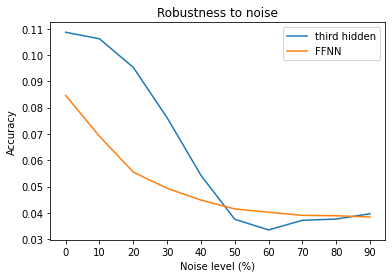

In [56]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plot_noise_robustness_curves(noise_levels)

**Conclusion:**

From this result we can conclude that the DBNetwork gives higher percentage of accuracy of the Ffnn, if the data is noisy.